# Building a Neural Network from Scratch

https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65 

### Abstract Base Class : Layer
The abstract class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.

In [57]:

# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In the abstract class above, backward_propagation function has an extra parameter, learning_rate, which is controlling the amount of learning/updating parameters using gradient descent.

### Backward Propagation
Suppose we have a matrix containing the derivative of the error with respect to that layer’s output: $\frac{\partial E}{\partial Y}$

We need :
- The derivative of the error with respect to the parameters ($\frac{\partial E}{\partial W}$, $\frac{\partial E}{\partial B}$)
- The derivative of the error with respect to the input ($\frac{\partial E}{\partial X}$)

Let's calculate $\frac{\partial E}{\partial W}$. This matrix should be the same size as $W$ itself : 

$i x j$ where $i$ is the number of input neurons and $j$ the number of output neurons. We need one gradient for every weight

### Coding the Fully Connected Layer

In [58]:
#from layer import Layer
import numpy as np

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of edges that connects to neurons in next layer
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

### Activation Layer
All the calculation we did until now were completely linear, may not learn well. We need to add non-linearity to the model by applying non-linear functions to the output of some layers.

Now we need to redo the whole process for this new type of layer!

In [59]:
#from layer import Layer

# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

You can also write some activation functions and their derivatives in a separate file. These will be used later to create an ActivationLayer.

In [60]:
import numpy as np

# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

# SIGMOID activation function and its derivative
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

# ReLU activation function and its derivative
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x


### Loss Function
Until now, for a given layer, we supposed that ∂E/∂Y was given (by the next layer). But what happens to the last layer? How does it get ∂E/∂Y? We simply give it manually, and it depends on how we define the error.
The error of the network, which measures how good or bad the network did for a given input data, is defined by you. 

There are many ways to define the error, and one of the most known is called MSE — Mean Squared Error.

In [61]:

import numpy as np

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

### Network Class
Almost done ! We are going to make a Network class to create neural networks very easily using the building blocks we have prepared so far.


In [62]:
# example of a function for calculating softmax for a list of numbers
from numpy import exp
 
# calculate the softmax of a vector
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [63]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

        
    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network 
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        '''
        Fit function does the training. 
        Training data is passed 1-by-1 through the network layers during forward propagation.
        Loss (error) is calculated for each input and back propagation is performed via partial 
        derivatives on each layer.
        '''
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

### Building Neural Networks
Finally ! We can use our class to create a neural network with as many layers as we want ! We are going to build two neural networks : a simple XOR and a MNIST solver.


### Solve XOR
Starting with XOR is always important as it’s a simple way to tell if the network is learning anything at all.

In [19]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(relu, relu_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(sigmoid, sigmoid_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)


epoch 1/1000   error=0.273759
epoch 2/1000   error=0.270950
epoch 3/1000   error=0.268572
epoch 4/1000   error=0.266562
epoch 5/1000   error=0.264865
epoch 6/1000   error=0.263434
epoch 7/1000   error=0.262227
epoch 8/1000   error=0.261210
epoch 9/1000   error=0.260352
epoch 10/1000   error=0.259629
epoch 11/1000   error=0.259019
epoch 12/1000   error=0.258503
epoch 13/1000   error=0.258068
epoch 14/1000   error=0.257699
epoch 15/1000   error=0.257387
epoch 16/1000   error=0.257121
epoch 17/1000   error=0.256896
epoch 18/1000   error=0.256704
epoch 19/1000   error=0.256539
epoch 20/1000   error=0.256399
epoch 21/1000   error=0.256278
epoch 22/1000   error=0.256174
epoch 23/1000   error=0.256084
epoch 24/1000   error=0.256005
epoch 25/1000   error=0.255937
epoch 26/1000   error=0.255877
epoch 27/1000   error=0.255824
epoch 28/1000   error=0.255777
epoch 29/1000   error=0.255735
epoch 30/1000   error=0.255698
epoch 31/1000   error=0.255664
epoch 32/1000   error=0.255633
epoch 33/1000   e

### Solve MNIST
We didn’t implemented the Convolutional Layer but this is not a problem. 
All we need to do is to reshape our data so that it can fit into a Fully Connected Layer.
MNIST Dataset consists of images of digits from 0 to 9, of shape 28x28x1. 
The goal is to predict what digit is drawn on a picture.

In [63]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# Network
net = Network()
net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(relu, relu_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(sigmoid, sigmoid_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=35, learning_rate=0.1)

# test on 3 samples
out = net.predict(x_test[0:10])
test = net.predict(x_train)
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test[0:3])

(60000, 28, 28)
epoch 1/35   error=0.099206
epoch 2/35   error=0.067142
epoch 3/35   error=0.054948
epoch 4/35   error=0.048092
epoch 5/35   error=0.043620
epoch 6/35   error=0.040832
epoch 7/35   error=0.039079
epoch 8/35   error=0.037723
epoch 9/35   error=0.036798
epoch 10/35   error=0.036164
epoch 11/35   error=0.035603
epoch 12/35   error=0.035005
epoch 13/35   error=0.034552
epoch 14/35   error=0.034220
epoch 15/35   error=0.033957
epoch 16/35   error=0.033768
epoch 17/35   error=0.033573
epoch 18/35   error=0.033330
epoch 19/35   error=0.033113
epoch 20/35   error=0.032964
epoch 21/35   error=0.032877
epoch 22/35   error=0.032779
epoch 23/35   error=0.032638
epoch 24/35   error=0.032555
epoch 25/35   error=0.032490
epoch 26/35   error=0.032431
epoch 27/35   error=0.032356
epoch 28/35   error=0.032309
epoch 29/35   error=0.032279
epoch 30/35   error=0.032243
epoch 31/35   error=0.032191
epoch 32/35   error=0.032121
epoch 33/35   error=0.032004
epoch 34/35   error=0.030651
epoch 3

In [65]:
ytemp = y_train
outtemp = np.array(test)
outtemp = outtemp.reshape(ytemp.shape)




# Evaluate Function

In [153]:
def evaluate(y, y_hat):
    y = np.reshape(y, y_hat.shape)
    confusion_matrix = np.zeros((y.shape[-1], y.shape[-1]))
    for i in range(y.shape[0]):
        prediction = np.argmax(y[i])
        true = np.argmax(y_hat[i])
        confusion_matrix[true][prediction] += 1
    diognal = []
    for i in range(confusion_matrix.shape[0]):
        diognal.append(confusion_matrix[i, i])
    precision_sum = np.sum(confusion_matrix, axis=0)
    recall_sum = np.sum(confusion_matrix, axis=1)
    all_samples = np.sum(recall_sum)
    accuracy = sum(diognal) / all_samples
    precision = np.average(diognal / precision_sum)
    recall = np.average(diognal / recall_sum)
    f1_score = 2 * precision * recall /  (precision + recall)
    print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1_score: {f1_score}")


In [91]:
evaluate(outtemp, ytemp)

0.6871666666666667 0.6307356832997879 0.6830839333725578 0.6558669181056928


# Dataset: Intel Image Classification

In [65]:
import os
import glob as gb
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [66]:
trainpath = 'archive/seg_train/'
testpath = 'archive/seg_test/'
predpath = 'archive/seg_pred/'

In [67]:
for folder in  os.listdir(trainpath + "seg_train") : #go on seg_train path
    files = gb.glob(pathname= str( trainpath +'seg_train//' + folder + '/*.jpg'))#get all files jpg
    print(f'For training data , found {len(files)} in folder {folder}')#print length for each class
    
for folder in  os.listdir(testpath + 'seg_test') : #go on seg_test path
    filess = gb.glob(pathname= str( testpath +'seg_test//' + folder + '/*.jpg'))#get all files jpg
    print(f'For test data , found {len(filess)} in folder {folder}')#print length for each class

files = gb.glob(pathname= str(predpath +'seg_pred/*.jpg'))#get all files jpg on seg_pred path
print(f'For Prediction data , found {len(files)}')#print length 

For training data , found 2191 in folder buildings
For training data , found 2271 in folder forest
For training data , found 2404 in folder glacier
For training data , found 2512 in folder mountain
For training data , found 2274 in folder sea
For training data , found 2382 in folder street
For test data , found 437 in folder buildings
For test data , found 474 in folder forest
For test data , found 553 in folder glacier
For test data , found 525 in folder mountain
For test data , found 510 in folder sea
For test data , found 501 in folder street
For Prediction data , found 7301


In [68]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x    #return the name of categories

checking the size of the images in all folders

In [69]:
size = []
for folder in  os.listdir(trainpath +'seg_train') : 
    files = gb.glob(pathname= str( trainpath +'seg_train//' + folder + '/*.jpg'))#go on seg_train path
    for file in files: 
        image = plt.imread(file)#read the image
        size.append(image.shape)#get the size of all image in size
pd.Series(size).value_counts()#count number of image have same shape

(150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
dtype: int64

In [70]:
size = []
for folder in  os.listdir(testpath +'seg_test') : 
    files = gb.glob(pathname= str( testpath +'seg_test//' + folder + '/*.jpg'))#go on seg_train path
    for file in files: 
        image = plt.imread(file)#read the image
        size.append(image.shape)#get the size of all image in size
pd.Series(size).value_counts()#count number of image have same shape

(150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
dtype: int64

In [71]:
size = []
files = gb.glob(pathname= str(predpath +'seg_pred/*.jpg'))
for file in files: 
    image = plt.imread(file)
    size.append(image.shape)
pd.Series(size).value_counts()

(150, 150, 3)    7288
(133, 150, 3)       1
(139, 150, 3)       1
(108, 150, 3)       1
(124, 150, 3)       1
(131, 150, 3)       1
(144, 150, 3)       1
(149, 150, 3)       1
(143, 150, 3)       1
(129, 150, 3)       1
(100, 150, 3)       1
(112, 150, 3)       1
(126, 150, 3)       1
(374, 500, 3)       1
dtype: int64

since most of them are (150, 150, 3), we should resize the rest to be the same 
### And
storing the images and its label in X_train, Y_train, X_test, Y_test, X_pred

In [124]:
s = 100
X_train = []
y_train = []
for folder in  os.listdir(trainpath +'seg_train') : #go on seg_train path
    files = gb.glob(pathname= str( trainpath +'seg_train//' + folder + '/*.jpg'))#get all files jpg
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))#resize all images to 100*100
        X_train.append(list(image_array))#list all images after resize in x_train
        y_train.append(code[folder])#get the names of images from code function

we have 14034 items in X_train
we have 14034 items in Y_train


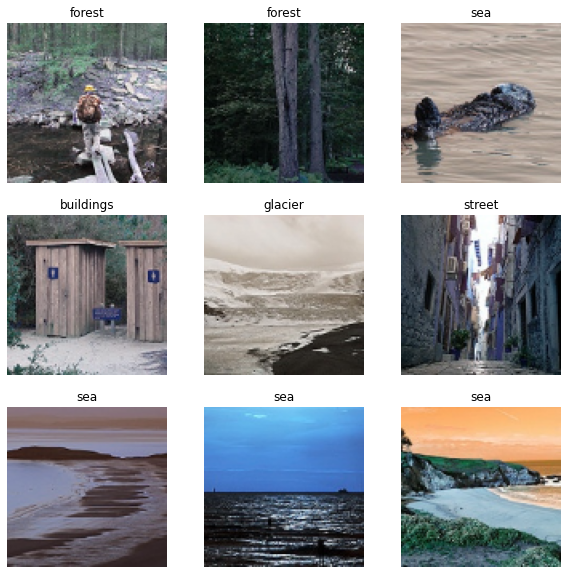

In [125]:
print(f'we have {len(X_train)} items in X_train')
print(f'we have {len(y_train)} items in Y_train')
plt.figure(figsize=(10,10))
for n , i in enumerate(list(np.random.randint(0,len(X_train),9))) : #print random images
    plt.subplot(3,3,n+1)
    plt.imshow(X_train[i])   
    plt.axis('off')
    plt.title(getcode(y_train[i]))

In [126]:
X_test = []
y_test = []
for folder in  os.listdir(testpath +'seg_test') : #go on seg_test path
    files = gb.glob(pathname= str(testpath + 'seg_test//' + folder + '/*.jpg'))#get all files jpg
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))#resize all images to 100*100
        X_test.append(list(image_array))#list all images after resize in x_test
        y_test.append(code[folder])#get the names of images from code function

we have 3000 items in X_test


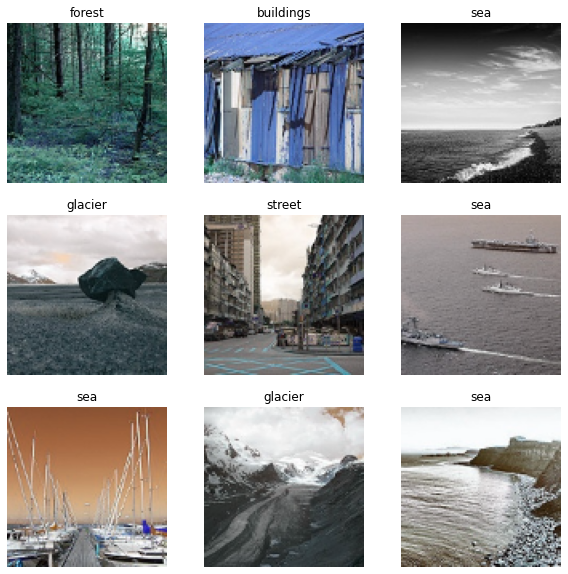

In [127]:
print(f'we have {len(X_test)} items in X_test')
plt.figure(figsize=(10,10))
for n , i in enumerate(list(np.random.randint(0,len(X_test),9))) : 
    plt.subplot(3,3,n+1)
    plt.imshow(X_test[i])    
    plt.axis('off')
    plt.title(getcode(y_test[i]))

In [128]:
X_pred = []
files = gb.glob(pathname= str(predpath + 'seg_pred/*.jpg'))#go on seg_pred path and get all files jpg
for file in files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (s,s))#resize images to 100*100
    X_pred.append(list(image_array))  #list all images after resize in x_pred

we have 7301 items in X_pred


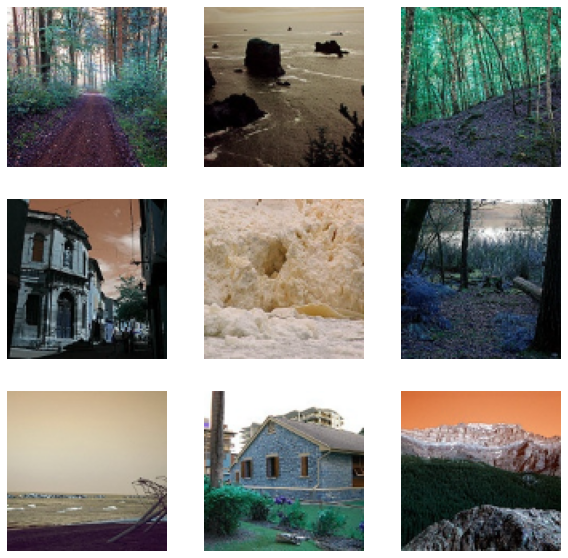

In [129]:
print(f'we have {len(X_pred)} items in X_pred')
plt.figure(figsize=(10,10))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),9))) : 
    plt.subplot(3,3,n+1)
    plt.imshow(X_pred[i])    
    plt.axis('off')

In [130]:
X_train = np.array(X_train)#get train ,test and pred arrays
X_test = np.array(X_test)
X_pred_array = np.array(X_pred)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'X_pred shape  is {X_pred_array.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')


X_train shape  is (14034, 100, 100, 3)
X_test shape  is (3000, 100, 100, 3)
X_pred shape  is (7301, 100, 100, 3)
y_train shape  is (14034,)
y_test shape  is (3000,)


Data is ready now we create the model

In [131]:
from keras.utils import np_utils
from sklearn.utils import shuffle 
# Training data: 14034 samples
# reshape and normalize input data
X_train = X_train.reshape(X_train.shape[0], 1, 100*100*3)
X_train = X_train.astype('float32')
X_train /= 255

y_train = np_utils.to_categorical(y_train)




X_test = X_test.reshape(X_test.shape[0], 1, 100*100*3)
X_test = X_test.astype('float32')
X_test /= 255

y_test = np_utils.to_categorical(y_test)



In [134]:
X_train, y_train = shuffle(X_train, y_train)

In [151]:
net = Network()
net.add(FCLayer(100*100*3, 100))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))
net.add(ActivationLayer(relu, relu_prime))
net.add(FCLayer(50, 36))
net.add(ActivationLayer(relu, relu_prime))
net.add(FCLayer(36, 6))
net.add(ActivationLayer(sigmoid, sigmoid_prime))

net.use(mse, mse_prime)

net.fit(X_train[:1000], y_train[:1000], epochs=15, learning_rate=0.1)

out = net.predict(X_test[:10])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test[0:10])

epoch 1/15   error=0.168917
epoch 2/15   error=0.143310
epoch 3/15   error=0.132796
epoch 4/15   error=0.130165
epoch 5/15   error=0.128298
epoch 6/15   error=0.127620
epoch 7/15   error=0.126628
epoch 8/15   error=0.125469
epoch 9/15   error=0.121628
epoch 10/15   error=0.121419
epoch 11/15   error=0.121646
epoch 12/15   error=0.119333
epoch 13/15   error=0.123291
epoch 14/15   error=0.125861
epoch 15/15   error=0.123946


predicted values : 
[array([[0.16881865, 0.18068316, 0.28181092, 0.0626811 , 0.12565886,
        0.19138775]]), array([[0.13207052, 0.07568462, 0.32628271, 0.08497604, 0.14868466,
        0.14887313]]), array([[0.17808929, 0.01910162, 0.02975653, 0.47894141, 0.15518335,
        0.12918305]]), array([[0.15155105, 0.03357042, 0.30451559, 0.19286888, 0.20577081,
        0.09059553]]), array([[0.07167135, 0.00959632, 0.22186607, 0.06412177, 0.10109403,
        0.17212728]]), array([[0.10103408, 0.48265711, 0.1122023 , 0.04670092, 0.06521978,
        0.18568365]]), array

In [154]:
outtemp = net.predict(X_train)


In [155]:
evaluate(outtemp, y_train)

accuracy: 0.38356847655693316, precision: 0.3088060077073259, recall: 0.3745707347879837, f1_score: 0.3385239386155162
